# Performance Analysis

In this part of the tutorial, we are going to explore the performances in Vienna 4*22 dataset from a set of expression attributes. 

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install partitura
    ! pip install partitura
    ! pip install fastdtw
    
    # To be able to access helper modules in the repo for this tutorial
    # (not necessary if the jupyter notebook is run locally instead of google colab)
    !git clone https://github.com/cpjku/vienna4x22.git
    ! pip install requests
    import requests
    # Save datagenerators as file to colab working directory
    # If you are using GitHub, make sure you get the "Raw" version of the code
    base = 'https://raw.githubusercontent.com/CPJKU/partitura_tutorial/main/notebooks/02_alignment/'
    for text in ["helper.py", "slideshow_helper.py", "alignment.py"]:
        r = requests.get(base+text)
        # make sure your filename is the same as how you want to import
        with open(text, 'w') as f:
            f.write(r.text)

In [1]:
import os, sys, warnings
from collections import defaultdict
sys.path.insert(0, "../../../partitura")
sys.path.insert(0, "../../../")
import partitura as pt
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')

Let's load a piece from the Vienna 4*22 dataset first. This Mozart piece contains many articulation markings and dynamic contrasts. To compute the expressions, both score and matched performance is needed. 

In [5]:
MATCH_DIR = "../../../Datasets/vienna4x22/match/"
MUSICXML_DIR = "../../../Datasets/vienna4x22/musicxml/"

match_fn = os.path.join(MATCH_DIR, 'Mozart_K331_1st-mov_p01.match')
score_fn = os.path.join(MUSICXML_DIR, 'Mozart_K331_1st-mov.musicxml')

mozart_score = pt.load_musicxml(score_fn)
mozart_performance, mozart_alignment = pt.load_match(match_fn)

score_part = mozart_score.parts[0]

## Articulation

In the work of Bresin et al. [1], the key overlap ratio (KOR) is defined as the ratio of overlap (or gap in the staccato case) and their inter onset interval(IOI) between the transitioning notes in the same voice. 

Score instructions such as **Legato** and **Staccato**, as well as **Repeated Notes** pattern, result in different articulations that is reflected by KOR. Thus, we compute 4 fields in the articulation category.
* `kor_`: 
* `kor_staccato`:
* `kor_legato`:
* `kor_repeated_notes`:

<img src="figures/kor.png" alt="key_overlap_ratio" width="600"/>
<img src="figures/mozart_score.png" alt="mozart_score" width="580"/>

[1] R.Bresin: Articulation Strategies in Expressive Piano Performance Analysis of Legato, Staccato, and Repeated Notes in Performances of the Andante Movement of Mozart's Sonata in G Major (K.545)

The Mozart piece contains 4 voices in a roughly homophonic texture, as shown in the score. The most prominent legato passage from m.17-m.18 (beat 96-108) and m.27-m.28 (beat 156-168) are reflected by the large KOR from the curve. Following the prominent legato passage, several notes with staccato marking shows up in the melodic voice (voice 1).

The staccato notes in the melody vocie are marked by the star sign, and we also plot the slur increase and decrese ramps on the top of the figure. In this performance, we can see that the staccato quality of these notes are very faithfully executed with a low KOR. 



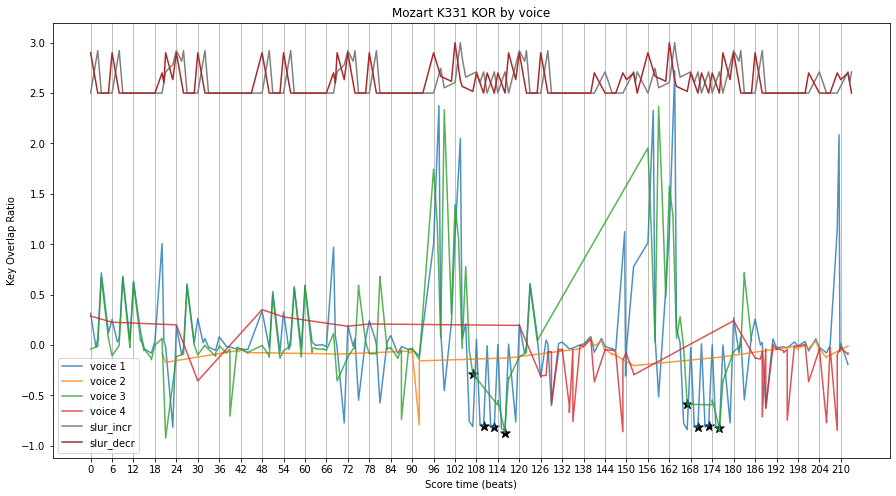

In [4]:
fig, ax = plt.subplots(1, figsize=(15, 8))
mozart_attributes = pt.musicanalysis.get_performance_expressions(mozart_score, mozart_performance, mozart_alignment)
m_score = mozart_attributes['m_score']
for voice in np.unique(m_score['voice']):
    voice_mask = m_score['voice'] == voice
    voice_notes = m_score[voice_mask]
    kor = mozart_attributes['articulations']['kor'][voice_mask]
    dummy_mask = (kor != -1)
    ax.plot(voice_notes['onset'][dummy_mask], kor[dummy_mask], label=f"voice {voice}", alpha=0.8)
    staccato_mask = voice_notes['articulation'] == 'staccato'
    ax.scatter(voice_notes['onset'][staccato_mask], kor[staccato_mask], c='black', s=100, marker="*")

incr_scaled = 2.5 + ((m_score['slur_feature.slur_incr'] - m_score['slur_feature.slur_incr'].min()) 
                   / (m_score['slur_feature.slur_incr'].max() - m_score['slur_feature.slur_incr'].min())) * 0.5
decr_scaled = 2.5 + ((m_score['slur_feature.slur_decr'] - m_score['slur_feature.slur_decr'].min()) 
                   / (m_score['slur_feature.slur_decr'].max() - m_score['slur_feature.slur_decr'].min())) * 0.5
ax.plot(m_score['onset'], incr_scaled, c='grey', label="slur_incr")
ax.plot(m_score['onset'], decr_scaled, c='brown', label="slur_decr")

# get starting time of each measure in the score
measure_times = score_part.beat_map([measure.start.t for measure in score_part.iter_all(pt.score.Measure)])
# do not include pickup measure
measure_times = measure_times[measure_times >= 0]

ax.set_title('Mozart K331 KOR by voice')
ax.set_xlabel('Score time (beats)')
ax.set_ylabel('Key Overlap Ratio')
ax.set_xticks(measure_times)
plt.legend()
plt.grid(axis='x')

# attributes['articulations']

Let's look at all performances of the same Mozart piece, and comparing how 22 performances' articulation in each voice. Voice 2 and 4 has less notes and thus less fluctuations in the figure.  We can also observe that voice 1 has occasional peaks of legato gesture, which corresponds to the slurred unit in the melody. In terms of staccato, large variance is demonstrated in among the pianists. 

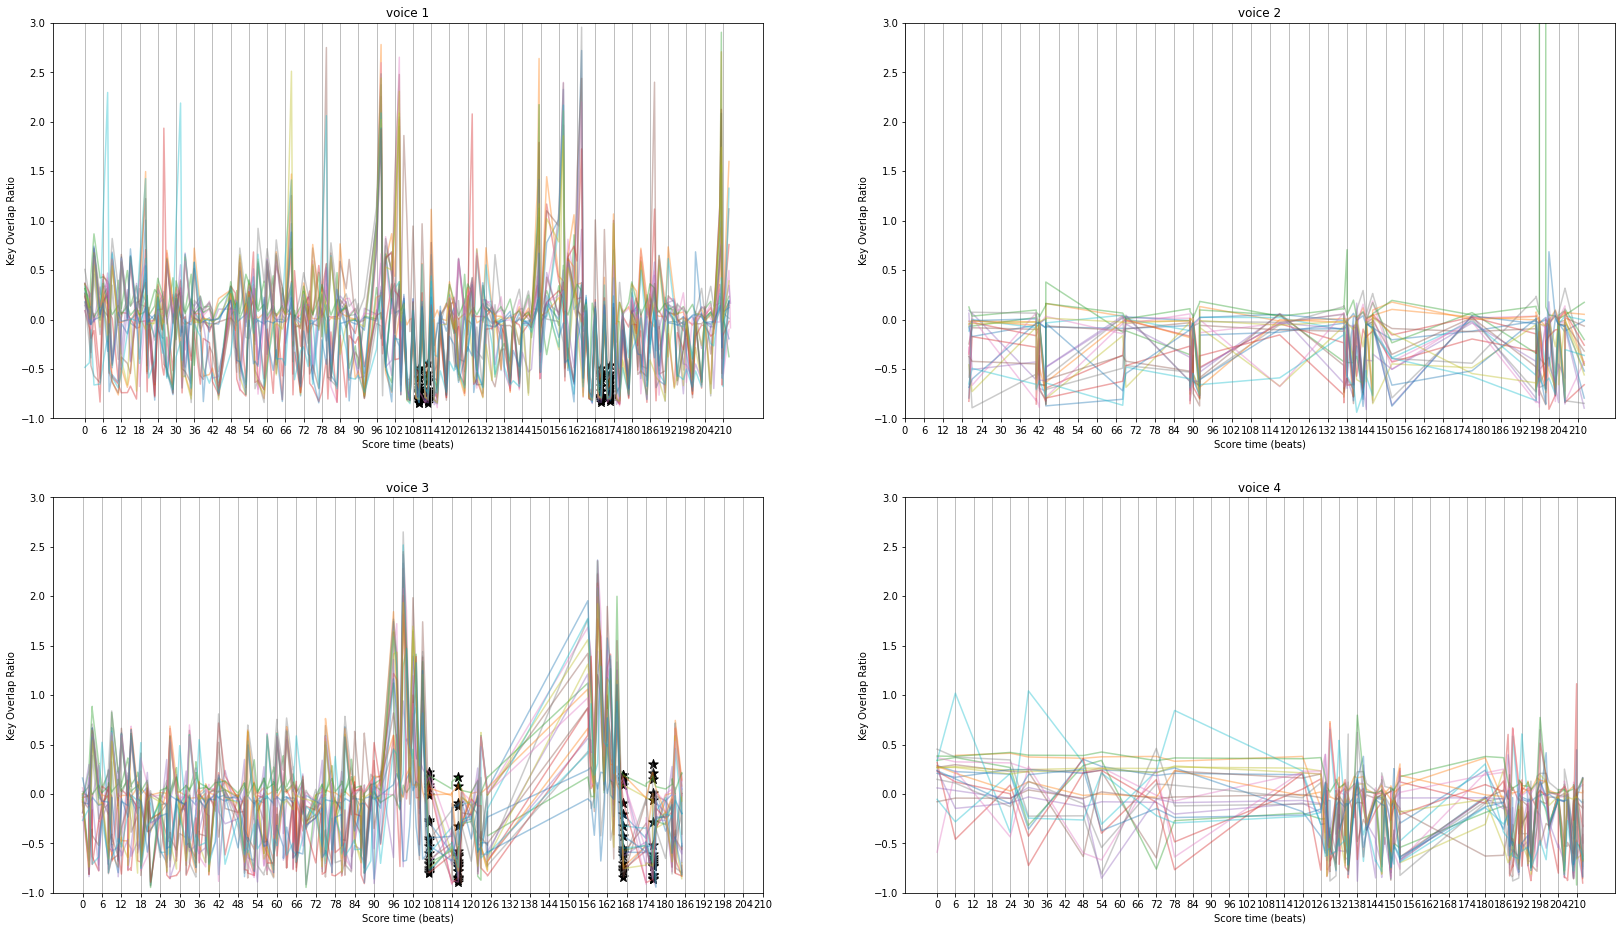

In [5]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(28, 16))

for i in range(1, 22):
    file_idx = str(i).zfill(2)
    match_fn = os.path.join(MATCH_DIR, f'Mozart_K331_1st-mov_p{file_idx}.match')
    performance, alignment = pt.load_match(match_fn)
    attributes = pt.musicanalysis.get_performance_expressions(mozart_score, performance, alignment)
    m_score = attributes['m_score']

    for voice, ax in zip(np.unique(m_score['voice']), [ax1, ax2, ax3, ax4]):
        voice_mask = m_score['voice'] == voice
        voice_notes = m_score[voice_mask]
        kor = attributes['articulations']['kor'][voice_mask]
        dummy_mask = (kor != -1)
        ax.plot(voice_notes['onset'][dummy_mask], kor[dummy_mask], label=f"voice {voice}", alpha=0.4)
        staccato_mask = voice_notes['articulation'] == 'staccato'
        ax.scatter(voice_notes['onset'][staccato_mask], kor[staccato_mask], c='black', s=100, marker="*")

# get starting time of each measure in the score
measure_times = score_part.beat_map([measure.start.t for measure in score_part.iter_all(pt.score.Measure)])
# do not include pickup measure
measure_times = measure_times[measure_times >= 0]

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.set_title(f'voice {i+1}')
    ax.set_xlabel('Score time (beats)')
    ax.set_ylabel('Key Overlap Ratio')
    ax.set_ylim((-1, 3))
    ax.set_xticks(measure_times)
    ax.grid(axis='x')



## Asynchrony

Asynchrony is an expression device frequently used by performers to highlight voices. In our expression attributes, we look at group of notes with the same score onset, and observe their micro-timing differences. 

* `delta`: The time difference between the earliest note and the latest note in this beat. 
* `pitch_cor`: The Person's correlation between between pitch and timing, normalized 
* `vel_cor`: The Person's correlation between between velocity and timing, normalized 
* `voice_std`: The standard deviation between voices within the asynchrnous group

<img src="figures/async_delta.png" alt="async_delta" width="600"/>
<img src="figures/async_cor.png" alt="async_cor" width="655"/>

To give us an impression of the timing difference of notes on the same beat, we look at how each voice's timing deviation from the central beat time. It can be observed that the top melodic voice (voice 1) is constantly being highlighted with a negative timing deviation (played slightly earlier). We can also observe a clear exibition of phrase boundries at m.17 and m.27, in which the melodic voice has a significant lagging effect compared to other voices, as the pianist trying to slow down. 

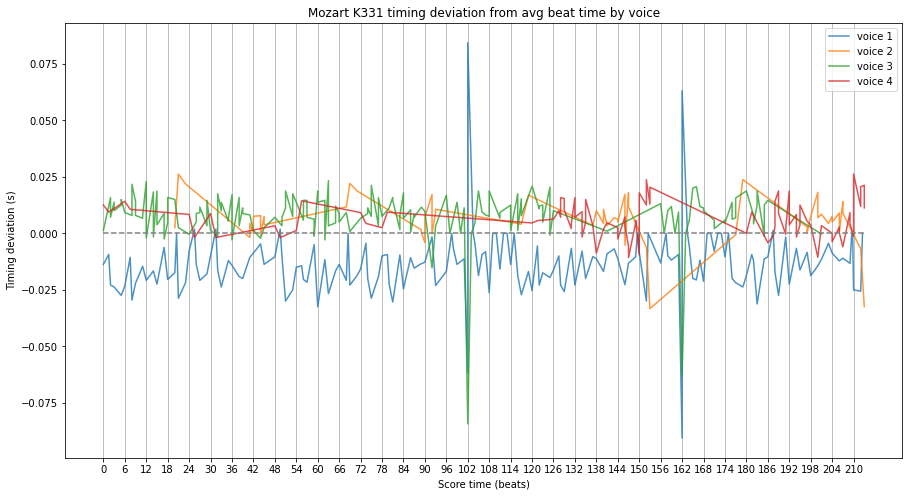

In [6]:
fig, ax = plt.subplots(1, figsize=(15, 8))
m_score = mozart_attributes['m_score']
_, stime_to_ptime_map = pt.utils.music.get_time_maps_from_alignment(
        mozart_performance.performedparts[0], mozart_score.parts[0], mozart_alignment)
for voice in np.unique(m_score['voice']):
    voice_mask = m_score['voice'] == voice
    voice_notes = m_score[voice_mask]
    timing_diff = voice_notes['p_onset'] - stime_to_ptime_map(voice_notes['onset'])

    ax.plot(voice_notes['onset'], timing_diff, label=f"voice {voice}", alpha=0.8)

ax.plot(voice_notes['onset'], np.zeros(len(voice_notes['onset'])), c='grey', linestyle='dashed')
ax.set_title('Mozart K331 timing deviation from avg beat time by voice')
ax.set_xlabel('Score time (beats)')
ax.set_ylabel('Timing deviation (s)')
ax.set_xticks(measure_times)
plt.legend()
plt.grid(axis='x')

Next we look at the 4 different attributes on the beat level scale, and compare 22 performances of this piece. Overall, the timing correlation with the pitch and velocity are high in this piece, and there is on average of ~40ms of asynchrony between voices. We also noticed that the asynchrony is significantly larger when it comes to phrase boundries. 

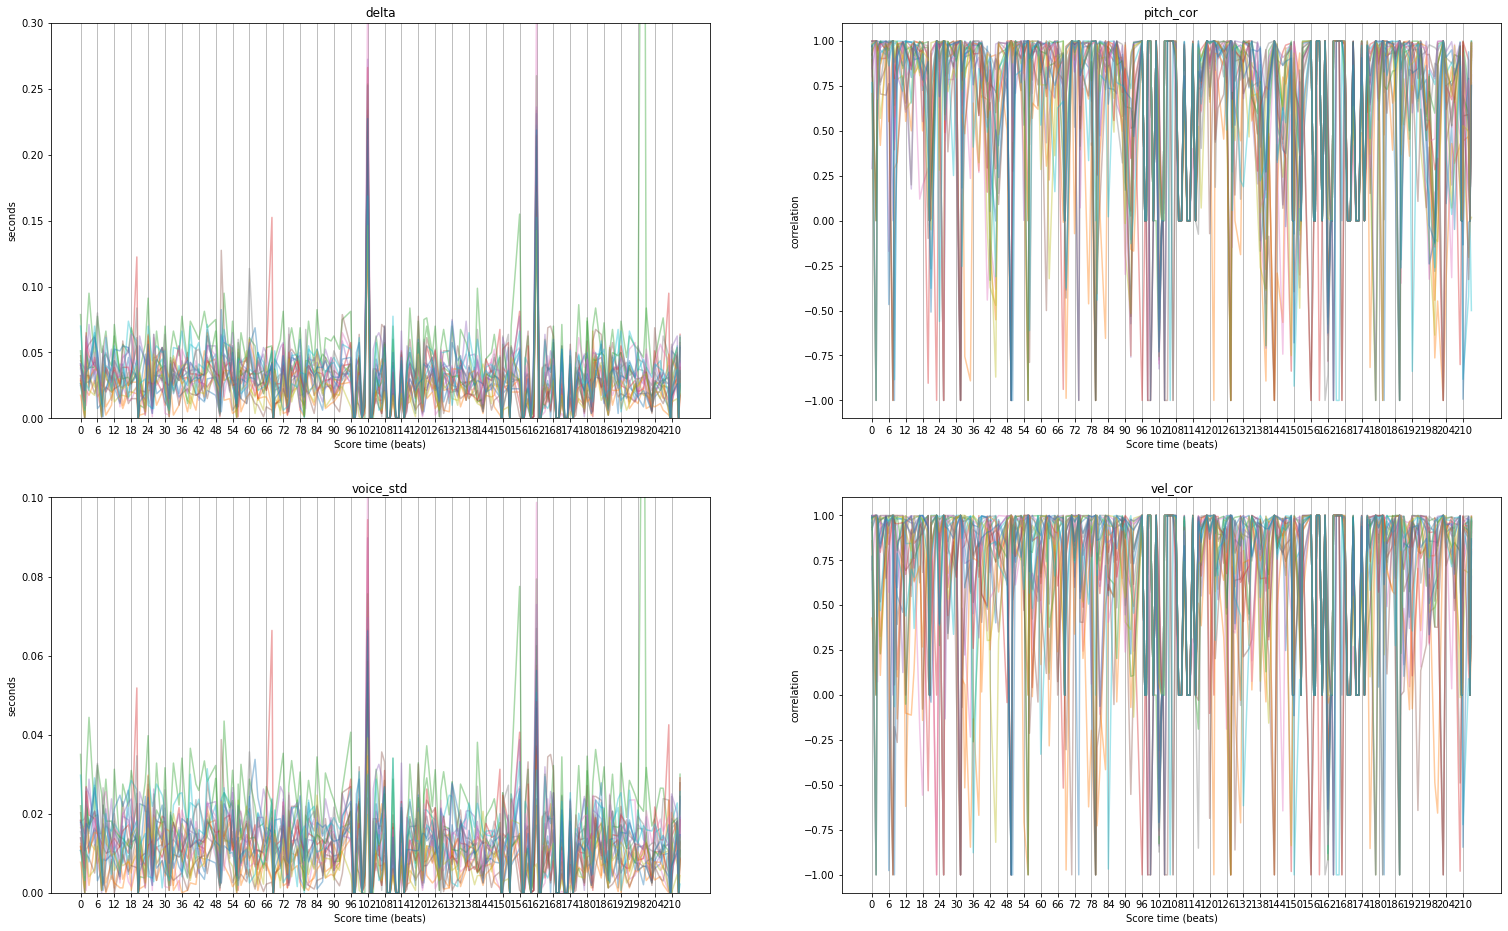

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(26, 16))

ylabels = ["seconds", "correlation", "seconds", "correlation"]


for i in range(1, 22):
    file_idx = str(i).zfill(2)
    match_fn = os.path.join(MATCH_DIR, f'Mozart_K331_1st-mov_p{file_idx}.match')
    performance, alignment = pt.load_match(match_fn)
    attributes = pt.musicanalysis.get_performance_expressions(mozart_score, performance, alignment)
    m_score = attributes['m_score']

    for i, (attribute, ax) in enumerate(zip(['delta', 'pitch_cor', 'voice_std', 'vel_cor'],
                        (ax1, ax2, ax3, ax4))):    
        ax.plot(np.unique(m_score['onset']), attributes['asynchrony'][attribute], alpha=0.4)
        ax.set_title(f'{attribute}')
        ax.set_xlabel('Score time (beats)')
        ax.set_ylabel(ylabels[i])
        ax.set_xticks(measure_times)
        ax.grid(axis='x')

    ax1.set_ylim((0, 0.3))
    ax3.set_ylim((0, 0.1))

## Dynamics

In the dynamics section, we look at how the performed dynamics relates to the score instructions. For the constant dynamic markings, we follow the research from [1] and consider the attributes of agreement and consistency: 
* `agreement`: For each pair of changing dynamics, computes the aggreement (kendalltau corrlation) of the OLS ordering and the performed velocity. 
* `consistency_std`: Compute the standard deviation of a score marking to see how consistent it's being executed throughout the piece.

For the changing dynamics markings, we compute:
* `ramp_cor`: Pearson's correlation between the overall velocity (averaged across voices) with the indicated crescendo / decrescendo ramp
* `tempo_cor`: Correlation between the dynamic change and tempo. "the faster the louder, the slower the softer."

<!-- <img src="figures/kor.png" alt="key_overlap_ratio" width="600"/> -->

[1] K.Kosta: Dynamics and relativity: Practical implications of dynamic markings in the score

For this metric, we are going to look at the piece Chopin Op.10 No.3 as it contains more dynamic instructions. Firstly, we plot the overall dynamics (velocity) trend, also in a voice-by-voice basis along with the markings. 

In [6]:
# match_fn = os.path.join(MATCH_DIR, 'Chopin_op10_no3_p01.match')
match_fn = os.path.join(MATCH_DIR, 'Schubert_D783_no15_p01.match')
# score_fn = os.path.join(MUSICXML_DIR, 'Chopin_op10_no3.musicxml')
score_fn = os.path.join(MUSICXML_DIR, 'Schubert_D783_no15.musicxml')

chopin_score = pt.load_musicxml(score_fn)
chopin_performance, chopin_alignment = pt.load_match(match_fn)

score_part = chopin_score.parts[0]

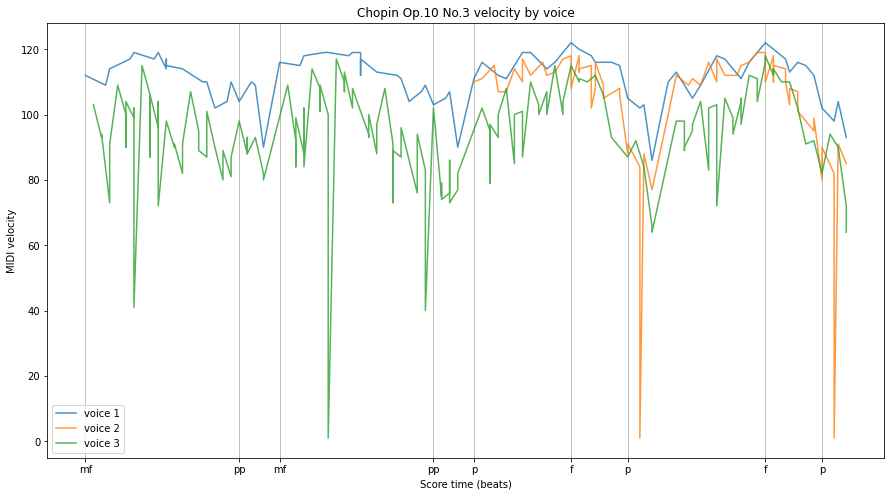

In [7]:
fig, ax = plt.subplots(1, figsize=(15, 8))
chopin_attributes = pt.musicanalysis.get_performance_expressions(chopin_score, chopin_performance, chopin_alignment)
m_score = chopin_attributes['m_score']

for voice in np.unique(m_score['voice']):
    voice_mask = m_score['voice'] == voice
    voice_notes = m_score[voice_mask]
    ax.plot(voice_notes['onset'], voice_notes['velocity'], label=f"voice {voice}", alpha=0.8)

ax.set_title('Chopin Op.10 No.3 velocity by voice')
ax.set_xlabel('Score time (beats)')
ax.set_ylabel('MIDI velocity')

# find the dynamics marking and plot them in the x axis.
beats_with_constant_dyn = np.unique(m_score[m_score['constant_dyn'] != 'N/A']['onset'])
markings = [m_score[m_score['onset'] == b]['constant_dyn'][0] for b in beats_with_constant_dyn]
ax.set_xticks(beats_with_constant_dyn, labels=markings)
plt.legend()
plt.grid(axis='x')

As we can see, the dynamics transition in this performance roughly agree with the OLS ordering. Lets plot all the aggreement values for 22 performances. 

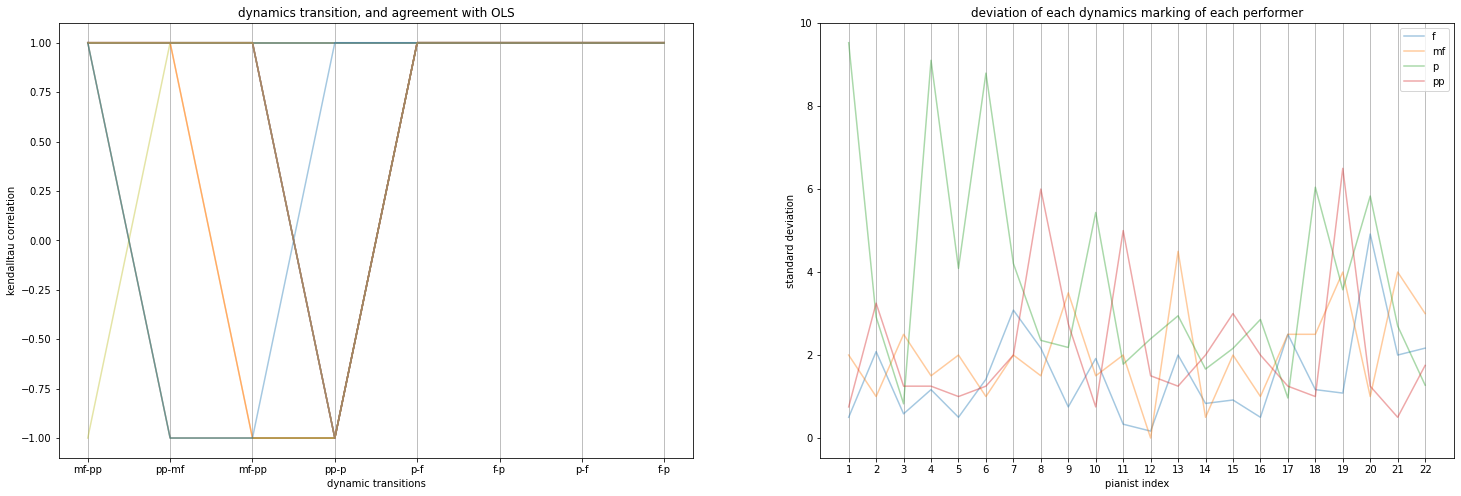

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8))

all_consistency = defaultdict(list)
for i in range(1, 23):
    file_idx = str(i).zfill(2)
    match_fn = os.path.join(MATCH_DIR, f'Schubert_D783_no15_p{file_idx}.match')
    performance, alignment = pt.load_match(match_fn)
    attributes = pt.musicanalysis.get_performance_expressions(chopin_score, performance, alignment)
    m_score = attributes['m_score']

    agreement = attributes['dynamics']['agreement'] 
    ax1.plot(range(len(agreement)), [t for m, t in agreement], alpha=0.4)

    consistency = attributes['dynamics']['consistency_std'] 
    for m, std in consistency:
        all_consistency[m].append(std)

ax1.set_title('dynamics transition, and agreement with OLS')
ax1.set_xlabel('dynamic transitions')
ax1.set_ylabel("kendalltau correlation")
ax1.set_xticks(range(len(agreement)), labels=[m for m, t in agreement])
ax1.grid(axis='x')

for m in all_consistency.keys():
    ax2.plot(range(1, 23), all_consistency[m], alpha=0.4, label=m)

ax2.set_title('deviation of each dynamics marking of each performer')
ax2.set_xlabel('pianist index')
ax2.set_ylabel("standard deviation")
ax2.set_xticks(range(1, 23))
ax2.legend()
ax2.grid(axis='x')



## Tempo

<!-- Asynchrony is a device frequently used by performers to highlight voices and . In our expression attributes, we look at group of notes with the same score onset, and 

* `delta`: 
* `pitch_cor`:
* `velocity_cor`:
* `voice_std`:

<img src="figures/async_delta.png" alt="async_delta" width="600"/>
<img src="figures/async_cor.png" alt="async_cor" width="655"/> -->



# From Expressions to Performers

In this section, we are going to look at the 22 pianists in the 4*22 group, and 